In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('inyo_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,92328,Inyo County,1,2015,Residential,46915.0,0.046915
1,92328,Inyo County,1,2015,Commercial,450763.0,0.450763
2,92389,Inyo County,1,2015,Residential,117402.0,0.117402
3,92389,Inyo County,1,2015,Commercial,159393.0,0.159393
4,93513,Inyo County,1,2015,Residential,173787.0,0.173787


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        703 non-null    int64  
 1   County         703 non-null    object 
 2   Month          703 non-null    int64  
 3   Year           703 non-null    int64  
 4   CustomerClass  703 non-null    object 
 5   TotalkWh       703 non-null    float64
 6   TotalGWh       703 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 38.6+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        703 non-null    int64         
 1   County         703 non-null    object        
 2   Month          703 non-null    int64         
 3   Year           703 non-null    int64         
 4   CustomerClass  703 non-null    object        
 5   TotalkWh       703 non-null    float64       
 6   TotalGWh       703 non-null    float64       
 7   Date           703 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 44.1+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,92328,Inyo County,1,2015,Residential,46915.0,0.046915
2015-01-01,92328,Inyo County,1,2015,Commercial,450763.0,0.450763
2015-01-01,92389,Inyo County,1,2015,Residential,117402.0,0.117402
2015-01-01,92389,Inyo County,1,2015,Commercial,159393.0,0.159393
2015-01-01,93513,Inyo County,1,2015,Residential,173787.0,0.173787


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,7302205.0,7.302205
2015-02-28,5799439.0,5.799439
2015-03-31,5722648.0,5.722648
2015-04-30,6576494.0,6.576494
2015-05-31,6182106.0,6.182106


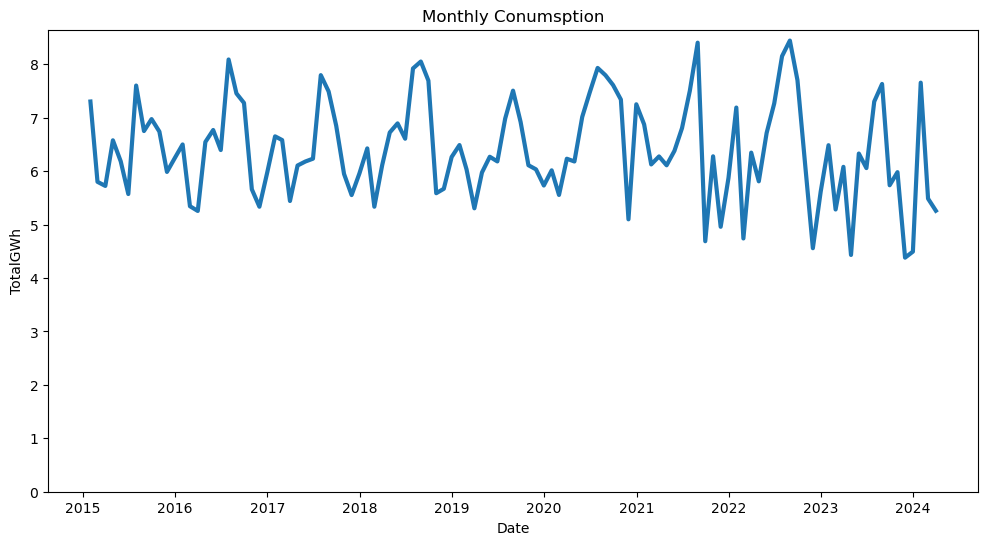

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.7201825533009945
p-value: 0.42074496249157256
Non-Stationary


***SARIMAX model can still handle non-stationary data***

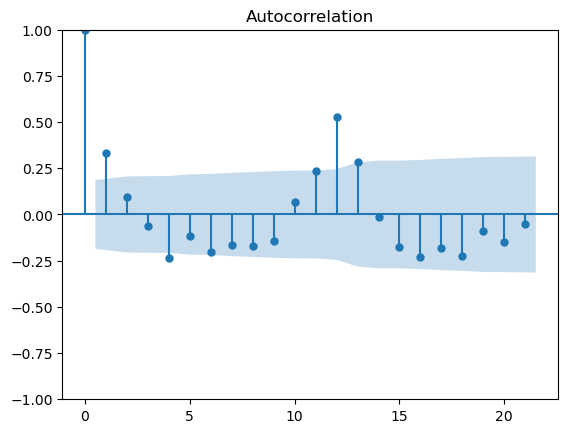

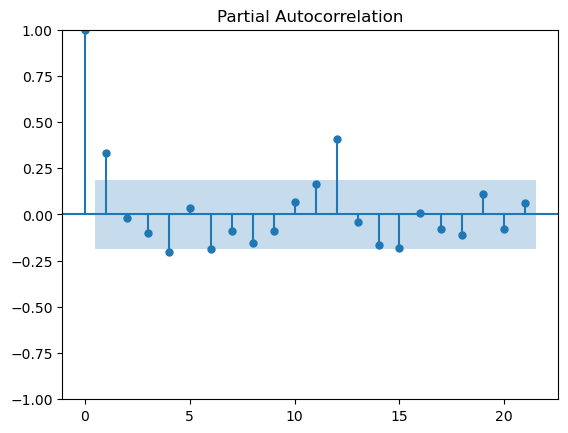

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=327.138, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=278.181, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=325.172, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=317.761, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=258.597, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=300.587, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=254.950, Time=0.49 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=255.510, Time=0.81 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=257.133, Time=0.70 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=282.924, Time=0.40 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=247.697, Time=0.80 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=24

In [18]:
# p, d, q parameters
model.order

(5, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(2, 0, 0, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

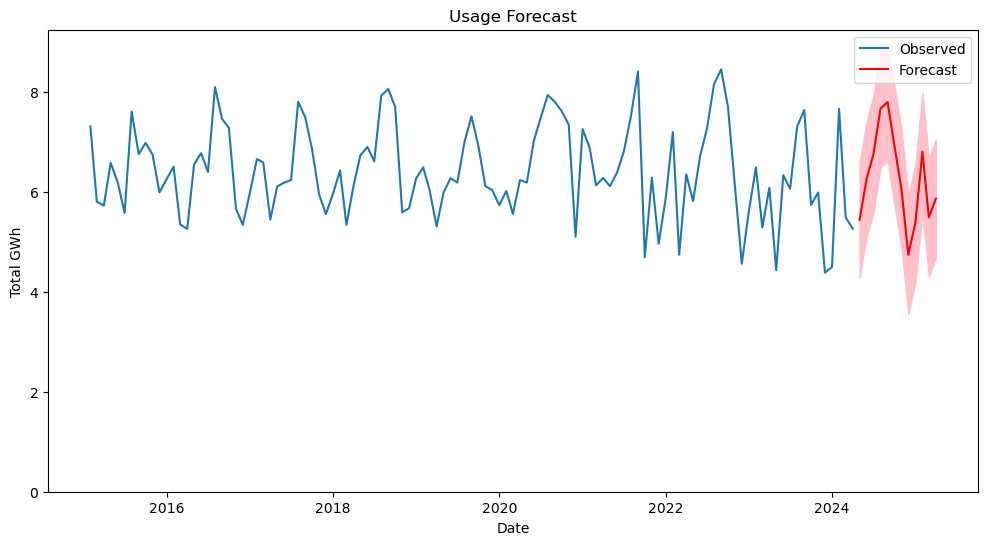

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

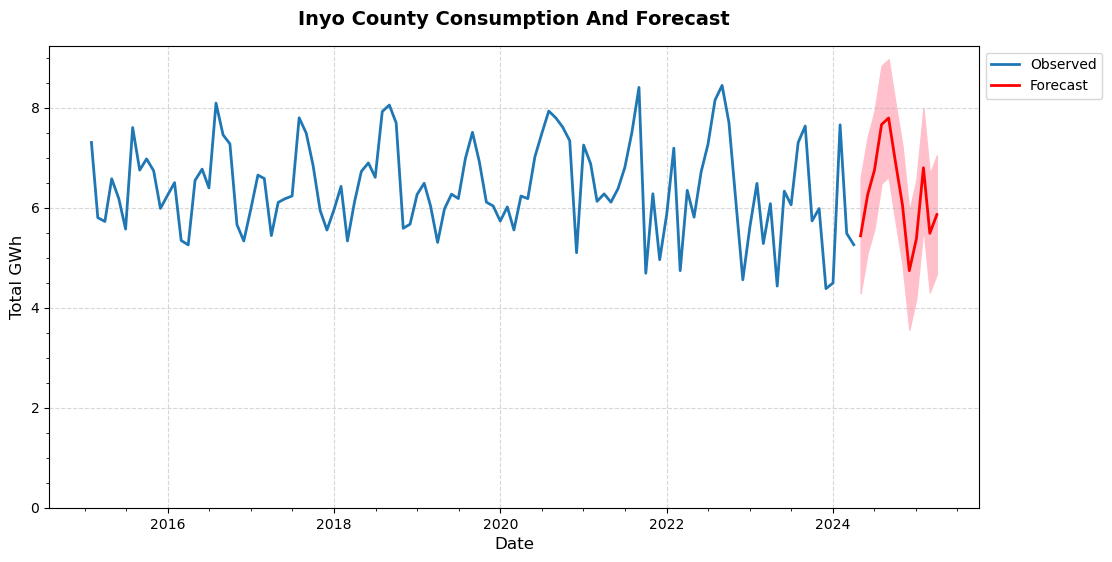

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Inyo County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')

# Show plot
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.5203141289167416
MSE: 0.4213715409755092
RMSE: 0.6491313742036424


In [24]:
observed

Date
2023-04-30    4.430978
2023-05-31    6.328926
2023-06-30    6.056326
2023-07-31    7.301838
2023-08-31    7.630765
2023-09-30    5.735227
2023-10-31    5.980633
2023-11-30    4.380394
2023-12-31    4.493084
2024-01-31    7.655193
2024-02-29    5.485043
2024-03-31    5.258233
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    5.436110
2024-05-31    6.255579
2024-06-30    6.750612
2024-07-31    7.660608
2024-08-31    7.791303
2024-09-30    6.915072
2024-10-31    6.049277
2024-11-30    4.738512
2024-12-31    5.375783
2025-01-31    6.796671
2025-02-28    5.486373
2025-03-31    5.860770
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

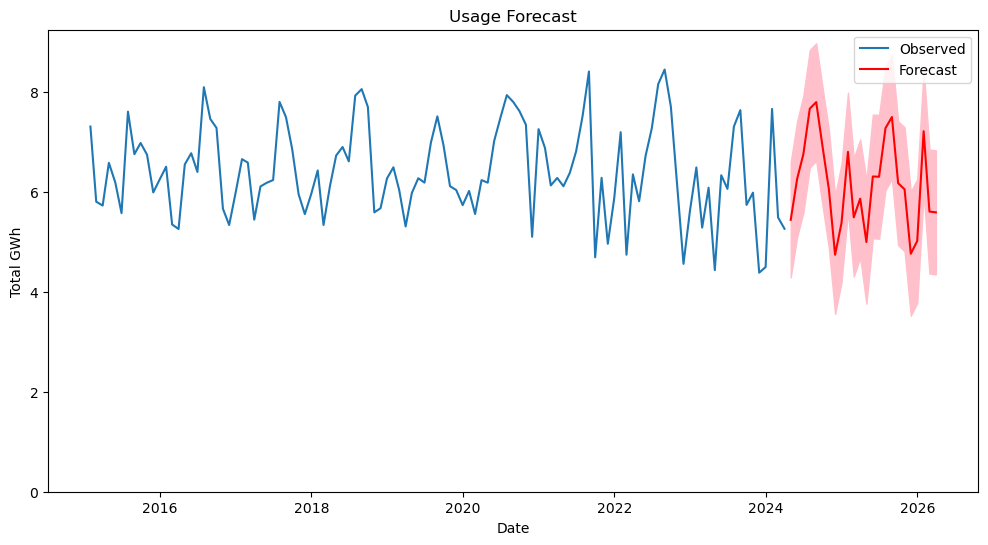

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.32358430792277537
MSE: 0.1458245885442094
RMSE: 0.38186985812474045


In [28]:
observed

Date
2022-04-30    5.808858
2022-05-31    6.714307
2022-06-30    7.265379
2022-07-31    8.150701
2022-08-31    8.442756
2022-09-30    7.701515
2022-10-31    6.094175
2022-11-30    4.557222
2022-12-31    5.615431
2023-01-31    6.484692
2023-02-28    5.281770
2023-03-31    6.079610
2023-04-30    4.430978
2023-05-31    6.328926
2023-06-30    6.056326
2023-07-31    7.301838
2023-08-31    7.630765
2023-09-30    5.735227
2023-10-31    5.980633
2023-11-30    4.380394
2023-12-31    4.493084
2024-01-31    7.655193
2024-02-29    5.485043
2024-03-31    5.258233
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30    5.436110
2024-05-31    6.255579
2024-06-30    6.750612
2024-07-31    7.660608
2024-08-31    7.791303
2024-09-30    6.915072
2024-10-31    6.049277
2024-11-30    4.738512
2024-12-31    5.375783
2025-01-31    6.796671
2025-02-28    5.486373
2025-03-31    5.860770
2025-04-30    4.993835
2025-05-31    6.303948
2025-06-30    6.298252
2025-07-31    7.269958
2025-08-31    7.492862
2025-09-30    6.169253
2025-10-31    6.047798
2025-11-30    4.759016
2025-12-31    5.013120
2026-01-31    7.209537
2026-02-28    5.601843
2026-03-31    5.586919
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum


CustomerClass
Agricultural    126.996266
Commercial      256.656881
Residential     326.939797
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,126.996266
1,Commercial,256.656881
2,Residential,326.939797


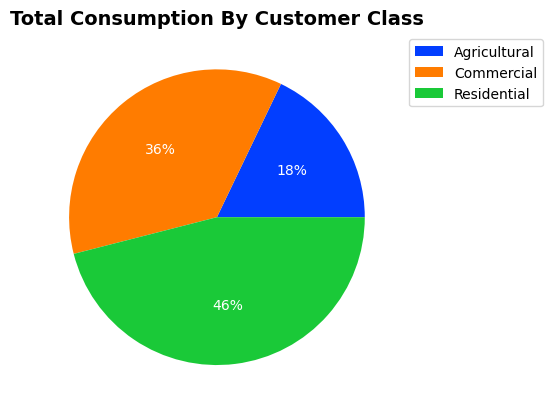

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

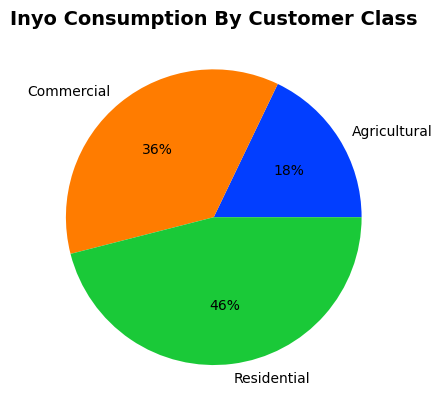

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],labels=customer_df['CustomerClass'],colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Inyo Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()